In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
train_df = pd.read_csv("../train.csv")
test_df = pd.read_csv("../test.csv")

In [3]:
merged_df = pd.concat([train_df, test_df])
df_labels = merged_df["Activity"].replace(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'],  [0, 1, 2, 3, 4, 5])
df_features = merged_df.drop(["Activity", "subject"], axis=1)

# KNN

In [18]:
knn = RandomizedSearchCV( KNeighborsClassifier(algorithm='auto'), {
    'n_neighbors' : range(1,10,1),
    'weights': ['uniform', 'distance'],
}, cv=5, return_train_score= False, n_iter=5)
knn.fit(df_features, df_labels)
print(f"Best Score in KNN: {knn.best_score_}\n Params: {knn.best_params_}")

Best Score in KNN: 0.9081458621161183
 Params: {'weights': 'uniform', 'n_neighbors': 7}


In [6]:
svm = RandomizedSearchCV( SVC(gamma='auto'),{
    'C': range(1,100),
    'kernel': ['rbf','linear'],
}, cv= 5, return_train_score= False, n_iter=10)
# svm.fit(df_features, df_labels)
print(f"Best Score in SVM: {svm.best_score_}\n Params: {svm.best_params_}")

Best Score in SVM: 0.9604818061364504
 Params: {'kernel': 'rbf', 'C': 97}


In [7]:
rfc = RandomizedSearchCV( RandomForestClassifier(),{
    'n_estimators':range(1,200),
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth':range(100,600,10)
}, cv=5, return_train_score=False, n_iter=10)
rfc.fit(df_features, df_labels)
print(f"Best Score in Random forest classifier: {rfc.best_score_}\n Params: {rfc.best_params_}")

Best Score in Random forest classifier: 0.9374698340697011
 Params: {'n_estimators': 196, 'max_depth': 140, 'criterion': 'entropy'}


# Running cross validation and making heatmap for the best parameters

In [5]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=False)

In [6]:
params = knn.best_params_
knn = KNeighborsClassifier(algorithm='auto', weights = params['weights'], n_neighbors = params['n_neighbors'])

In [7]:
np_X = df_features.values.reshape(df_features.shape[0], df_features.shape[1])
np_y = df_labels.values.reshape(df_labels.shape[0])

In [20]:
knn_cfs = []
for train_index,test_index in kfold.split(np_X):
    X_train, X_test = np_X[train_index], np_X[test_index]
    y_train, y_test = np_y[train_index], np_y[test_index]
    knn = KNeighborsClassifier(algorithm='auto', weights = params['weights'], n_neighbors = params['n_neighbors'])
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    original = y_test
    cf = metrics.confusion_matrix(pred, original)
    knn_cfs.append(cf)

In [17]:
params = svm.best_params_
svm = SVC(gamma='auto', C = params['C'], kernel=params['kernel'])

In [18]:
svm_cfs=[]
for train_index,test_index in kfold.split(np_X):
    X_train, X_test = np_X[train_index], np_X[test_index]
    y_train, y_test = np_y[train_index], np_y[test_index]
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    original = y_test
    cf = metrics.confusion_matrix(pred, original)
    svm_cfs.append(cf)

In [19]:
params = rfc.best_params_
rfc = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'], criterion=params['criterion'])

In [20]:
rfc_cfs=[]
for train_index,test_index in kfold.split(np_X):
    X_train, X_test = np_X[train_index], np_X[test_index]
    y_train, y_test = np_y[train_index], np_y[test_index]
    rfc.fit(X_train, y_train)
    pred = rfc.predict(X_test)
    original = y_test
    cf = metrics.confusion_matrix(pred, original)
    rfc_cfs.append(cf)

In [45]:
from math import floor,ceil,sqrt

In [15]:
def heatmap_drawing(confusion_matrices, title):
    rows=5
    col = 1
    fig, axs = plt.subplots(rows,col, figsize=(7,20))
    for i,cm in enumerate(confusion_matrices):
        ax = axs[i]
        sns.heatmap(cm, annot=True, ax=ax,fmt='d')
        ax.set_title(f"{title} {i+1}")
    plt.tight_layout()
    plt.show()

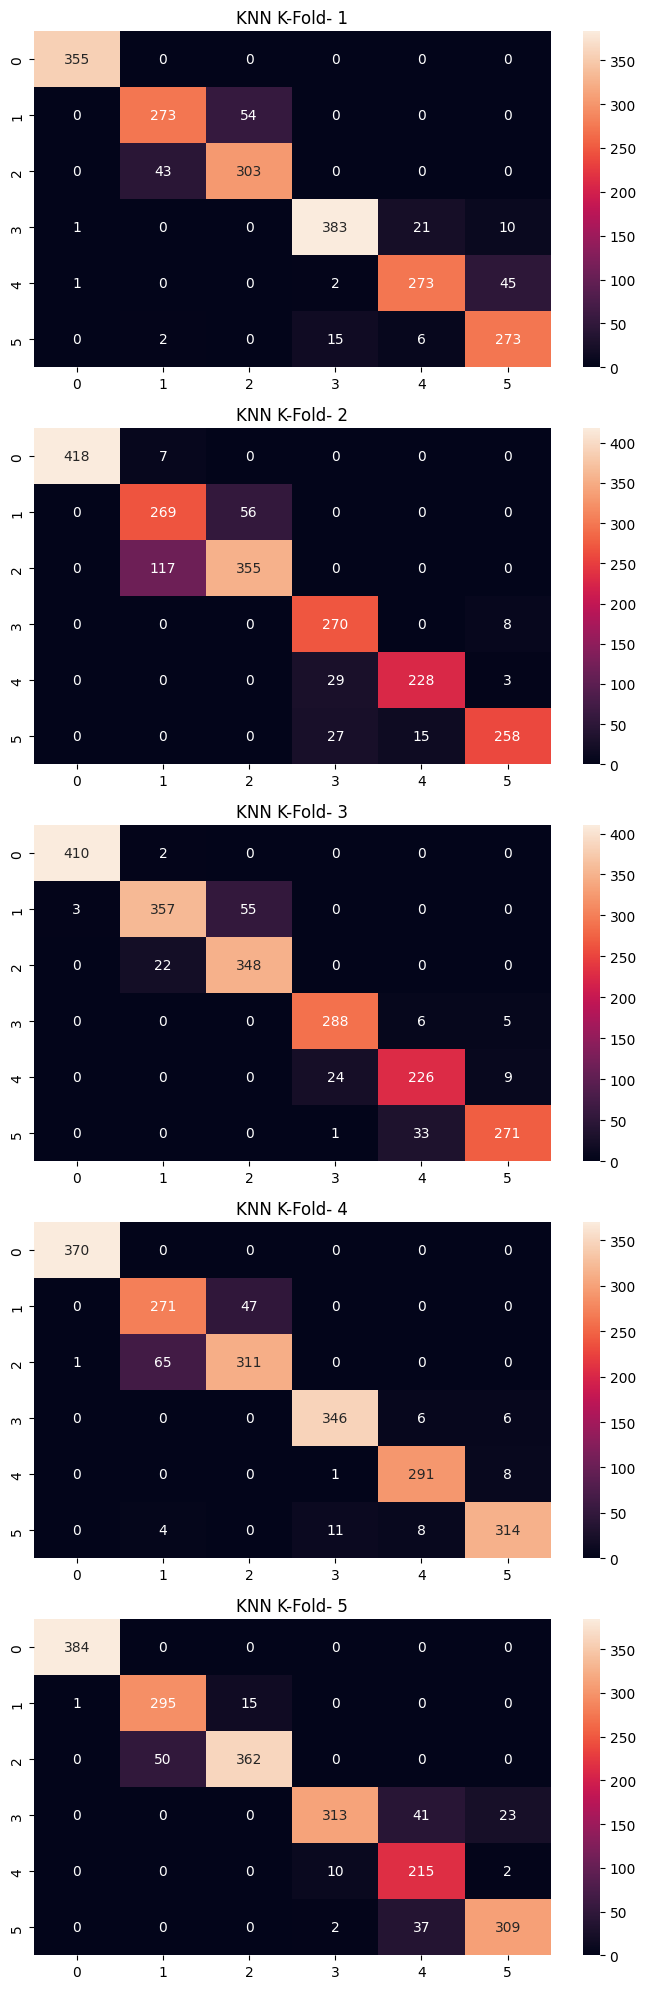

In [16]:
heatmap_drawing(knn_cfs,'KNN K-Fold-')

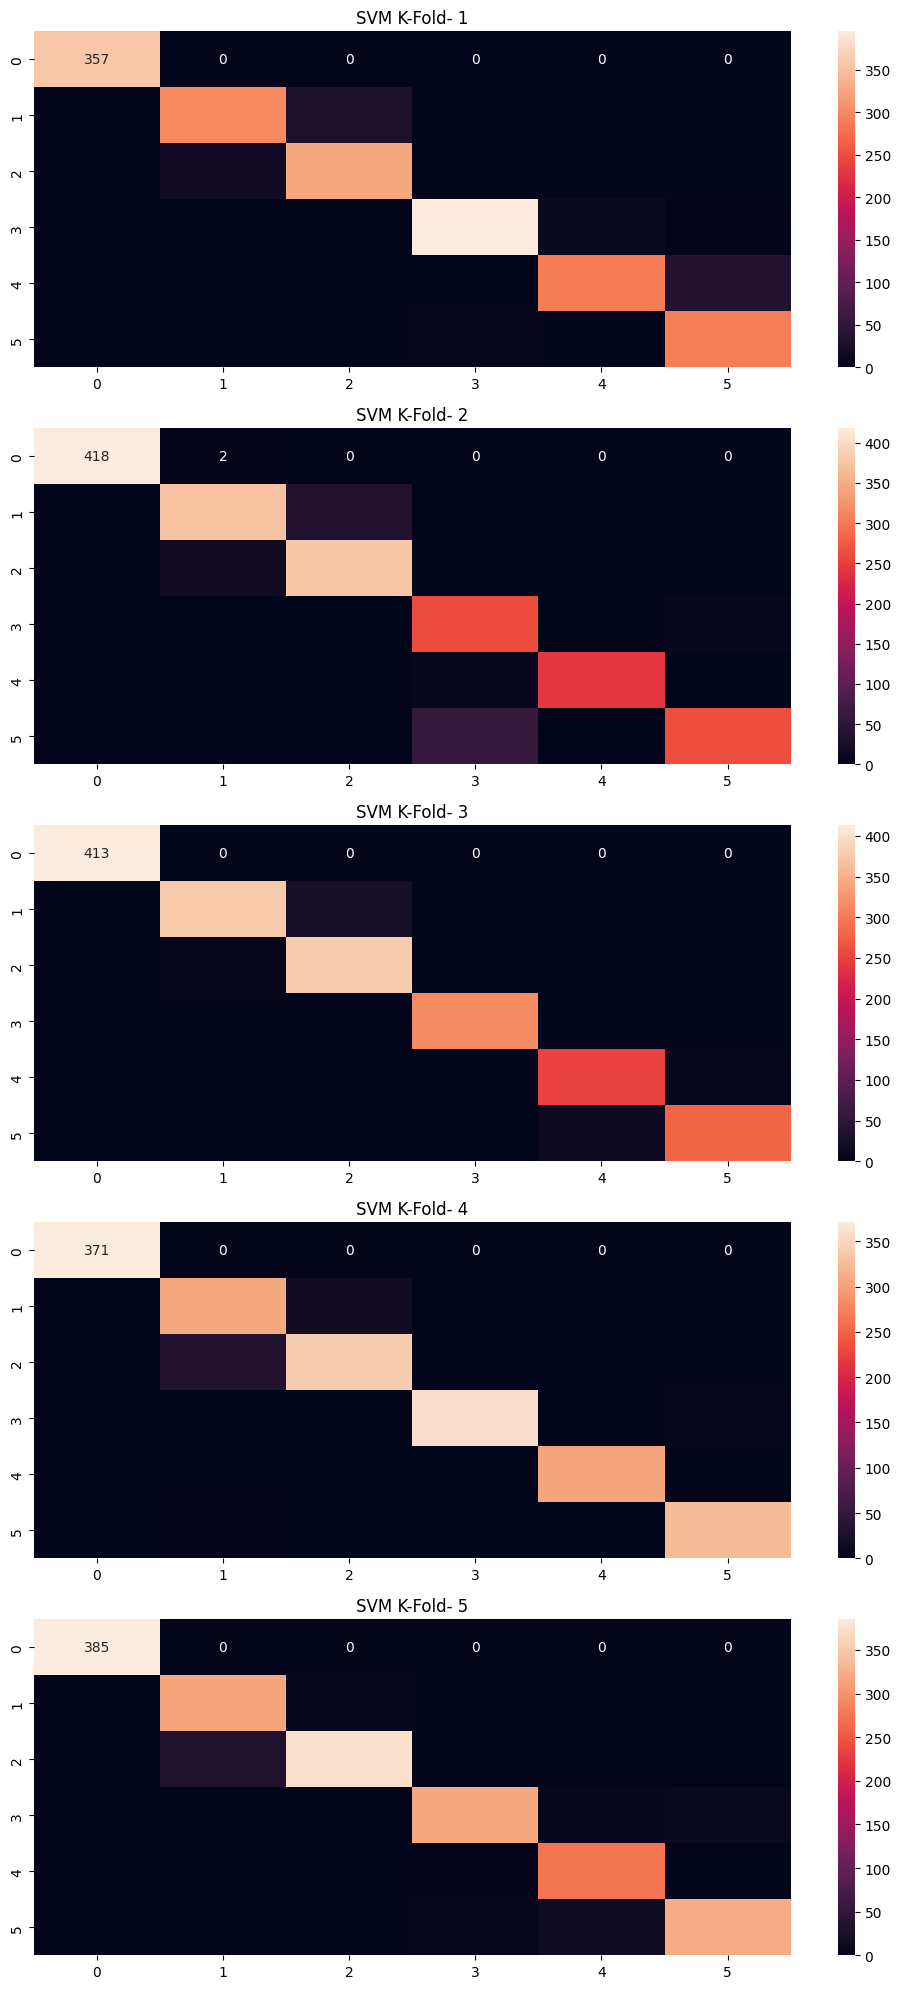

In [59]:
heatmap_drawing(svm_cfs,'SVM K-Fold-')

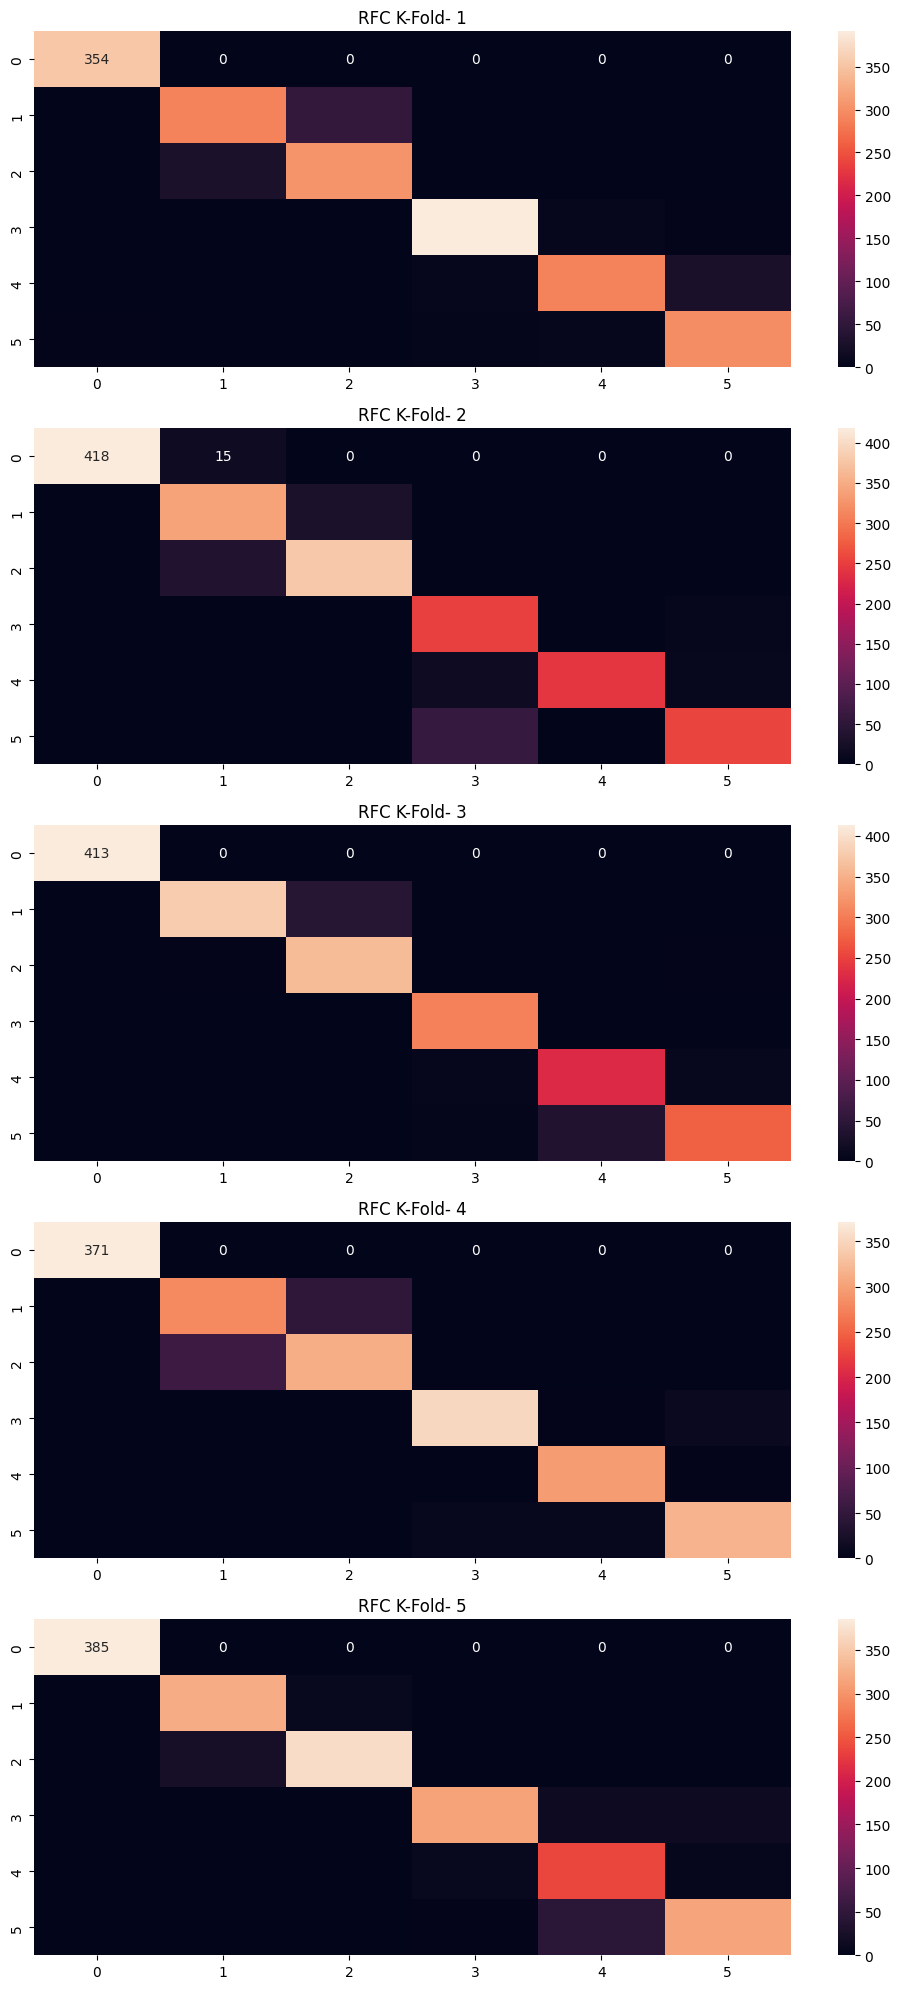

In [60]:
heatmap_drawing(rfc_cfs,'RFC K-Fold-')

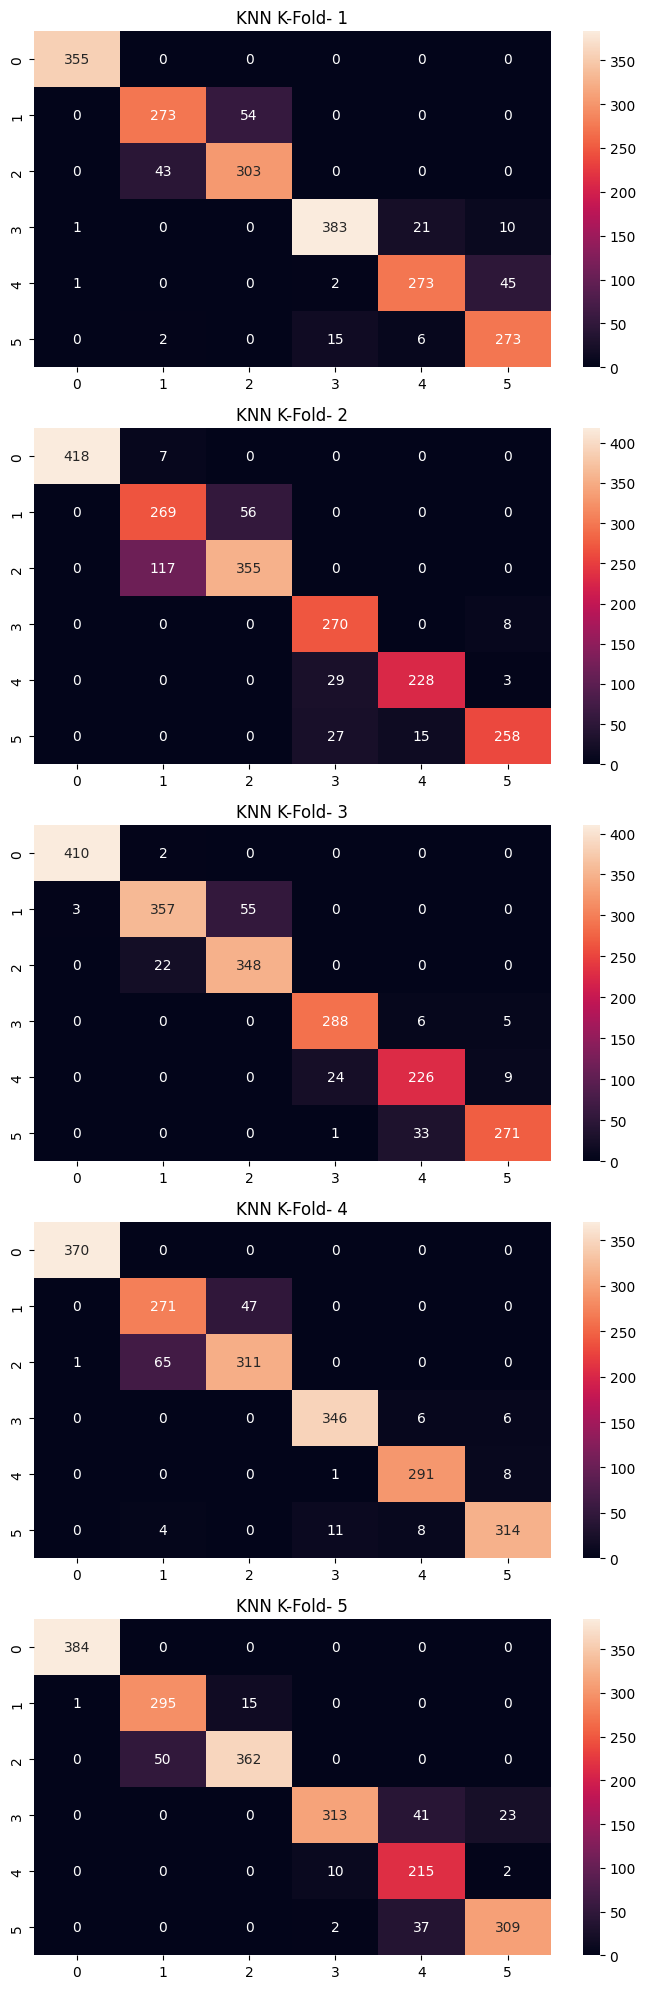

In [21]:
heatmap_drawing(knn_cfs,'KNN K-Fold-')

In [65]:
np.save("KNN_cnfs.npy", np.array(knn_cfs))

In [66]:
np.save("SVM_cnfs.npy", np.array(svm_cfs))

In [67]:
np.save("RFC_cnfs.npy", np.array(rfc_cfs))